# Multiclass semantic segmentation using DeepLabV3+

**Author:** [Soumik Rakshit](http://github.com/soumik12345)<br>
**Date created:** 2021/08/31<br>
**Last modified:** 2021/09/1<br>
**Description:** Implement DeepLabV3+ architecture for Multi-class Semantic Segmentation.

## Introduction

Semantic segmentation, with the goal to assign semantic labels to every pixel in an image,
is an essential computer vision task. In this example, we implement
the **DeepLabV3+** model for multi-class semantic segmentation, a fully-convolutional
architecture that performs well on semantic segmentation benchmarks.

### References:

- [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)
- [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915)

## Downloading the data

We will use the [Crowd Instance-level Human Parsing Dataset](https://arxiv.org/abs/1811.12596)
for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images.
Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification.
This dataset can be used for the "human part segmentation" task.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
# !gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
# !unzip -q instance-level-human-parsing.zip

## Creating a TensorFlow Dataset

Training on the entire CIHP dataset with 38,280 images takes a lot of time, hence we will be using
a smaller subset of 200 images for training our model in this example.

In [3]:
# IMAGE_SIZE = 128
# BATCH_SIZE = 16
# NUM_CLASSES = 20
# DATA_DIR = "C:/kaggletemp/sartorius-cell-instance-segmentation/instance-level_human_parsing/instance-level_human_parsing/Training"
# NUM_TRAIN_IMAGES = 1000
# NUM_VAL_IMAGES = 50

# train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
# train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
# val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
#     NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
# ]
# val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
#     NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
# ]
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 3
DATA_DIR = "C:/kaggletemp/sartorius-cell-instance-segmentation"
NUM_TRAIN_IMAGES = np.floor(.9 * 602).astype( "int")


NUM_VAL_IMAGES = 602 - NUM_TRAIN_IMAGES

train_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[
    (NUM_TRAIN_IMAGES + 1) : (NUM_VAL_IMAGES + NUM_TRAIN_IMAGES)
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[
    (NUM_TRAIN_IMAGES +1): (NUM_VAL_IMAGES + NUM_TRAIN_IMAGES)
]

In [4]:
im = sorted(glob(os.path.join(DATA_DIR, "train/*")))
ms = sorted(glob(os.path.join(DATA_DIR, "mask/*")))
data = { 'img' : im, 'mask' : ms}
td = pd.DataFrame(data= data)
td.iloc[2,]
td = td.sample(frac=1).reset_index(drop=True)
train_images = td['img'].iloc[:NUM_TRAIN_IMAGES]
train_masks =  td['mask'].iloc[:NUM_TRAIN_IMAGES]
val_images = td['img'].iloc[
    (NUM_TRAIN_IMAGES + 1) : (NUM_VAL_IMAGES + NUM_TRAIN_IMAGES)
]
val_masks = td['mask'].iloc[
    (NUM_TRAIN_IMAGES +1): (NUM_VAL_IMAGES + NUM_TRAIN_IMAGES)
]

ValueError: All arrays must be of the same length

In [5]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image =  tf.image.convert_image_dtype(image, dtype=tf.float32)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        #image = image / 255
       # image = tf.clip_by_value(image,0,1)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)



Train Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [6]:
 train_dataset.__iter__().next()
#tf.math.reduce_max(x)

(<tf.Tensor: shape=(4, 512, 512, 3), dtype=float32, numpy=
 array([[[[0.57875496, 0.57875496, 0.57875496],
          [0.5882736 , 0.5882736 , 0.5882736 ],
          [0.5207836 , 0.5207836 , 0.5207836 ],
          ...,
          [0.46787494, 0.46787494, 0.46787494],
          [0.4913067 , 0.4913067 , 0.4913067 ],
          [0.518099  , 0.518099  , 0.518099  ]],
 
         [[0.61714154, 0.61714154, 0.61714154],
          [0.56036115, 0.56036115, 0.56036115],
          [0.45212546, 0.45212546, 0.45212546],
          ...,
          [0.49729055, 0.49729055, 0.49729055],
          [0.5381262 , 0.5381262 , 0.5381262 ],
          [0.5431105 , 0.5431105 , 0.5431105 ]],
 
         [[0.5044348 , 0.5044348 , 0.5044348 ],
          [0.49269113, 0.49269113, 0.49269113],
          [0.44942558, 0.44942558, 0.44942558],
          ...,
          [0.5169367 , 0.5169367 , 0.5169367 ],
          [0.5017827 , 0.5017827 , 0.5017827 ],
          [0.48998356, 0.48998356, 0.48998356]],
 
         ...,
 
       

In [7]:

# def read_image(image_path, mask=False):
#     image = tf.io.read_file(image_path)
#     if mask:
#         image = tf.image.decode_png(image, channels=1)
#         image.set_shape([None, None, 1])
#         image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     else:
#         image = tf.image.decode_png(image, channels=3)
#         image.set_shape([None, None, 3])
#         image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
#         #image = image / 127.5 - 1
#         #image = tf.clip_by_value(image,0,1)
#     return image
#
# DATA_DIR = "C:/kaggletemp/sartorius-cell-instance-segmentation/train/"
# imid = '0ba181d412da.png'
# image_path= DATA_DIR +  "0ba181d412da.png"  #os.path.join(DATA_DIR, "0ba181d412da.png")
# image_path
# read_image(image_path, mask= False )
# train_images[:2]
# train_images

In [8]:
# IMAGE_SIZE = 128
# BATCH_SIZE = 16
# NUM_CLASSES = 3
# DATA_DIR = "C:/kaggletemp/sartorius-cell-instance-segmentation"
# NUM_TRAIN_IMAGES = 500
# NUM_VAL_IMAGES = 602 - NUM_TRAIN_IMAGES
# train_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[:NUM_TRAIN_IMAGES]
#
# train_images
# sorted(glob(os.path.join(DATA_DIR, "train/*")))
#
# np.floor(.8 * 602).astype( "int")

## Building the DeepLabV3+ model

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)

**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the
sampling rate becomes larger, the number of valid filter weights (i.e., weights that
are applied to the valid feature region, instead of padded zeros) becomes smaller.

In [9]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def dice_coe(output, target, axis = None, smooth=1e-10):
    output = tf.dtypes.cast( tf.math.greater(output, 0.5), tf. float32 )
    target = tf.dtypes.cast( tf.math.greater(target, 0.5), tf. float32 )
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)

    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice
#
# def dice_loss(y_true, y_pred):
#     return 1 - dice_coe(y_true, y_pred)
#
#
# def bce_dice_loss(y_true, y_pred):
#     return  .5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + \
#             (1 -.5) * dice_loss(y_true, y_pred)

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / ( tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return (1 - dice_coef(y_true, y_pred))+tf.keras.losses.binary_crossentropy(y_true,y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [10]:
# a = np.array([1,1,1,0] )
# b = np.array( [1,1,1,1] )
# dice_loss(a,b)

The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [11]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [68]:
# CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'C:/kaggletemp/sartorius-cell-instance-segmentation/models/models_3channel1.h5',
                                                verbose= 1, monitor='val_dice_coef', patience=10,
                                                mode='max', save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10,
                                              restore_best_weights=True)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8, min_lr=0.00001)


In [69]:
#loss = keras.losses.binary_crossentropy
#losses = keras.SparseCategoricalCrossentropy#from_logits=True)
loss = keras.losses.sparse_categorical_crossentropy
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss= loss,
    metrics= [ dice_coef] ,
)

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks = [checkpoint, reduce,early_stop],
                    )

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["dice_coe"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_dice_coe"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


Epoch 1/100


ValueError: in user code:

    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\rpsan\AppData\Local\Temp/ipykernel_17012/3394662547.py:63 dice_coef  *
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\ops\math_ops.py:1383 binary_op_wrapper
        raise e
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\ops\math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\ops\math_ops.py:1710 _mul_dispatch
        return multiply(x, y, name=name)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\ops\math_ops.py:530 multiply
        return gen_math_ops.mul(x, y, name)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\ops\gen_math_ops.py:6245 mul
        "Mul", x=x, y=y, name=name)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\framework\op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\framework\func_graph.py:601 _create_op_internal
        compute_device)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\framework\ops.py:3569 _create_op_internal
        op_def=op_def)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\framework\ops.py:2042 __init__
        control_input_ops, op_def)
    C:\kaggletemp\sartorius-cell-instance-segmentation\env\Lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 1048576 and 3145728 for '{{node mul_1}} = Mul[T=DT_FLOAT](Reshape, Reshape_1)' with input shapes: [1048576], [3145728].


## Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [86]:
#model <- tf.
# Loading the Colormap
colormap = loadmat(
    "C:/kaggletemp/sartorius-cell-instance-segmentation/instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)
#colormap = colormap[0:3]
colormap
#colormap = np.array ( [[1,0,0],[0,1,0],[0,0,1]] )
#colormap.shape

array([[ 0,  0,  0],
       [50,  0,  0],
       [99,  0,  0],
       [ 0, 33,  0],
       [66,  0, 19],
       [99, 33,  0],
       [ 0,  0, 33],
       [ 0, 46, 86],
       [33, 33,  0],
       [ 0, 33, 33],
       [33, 19,  0],
       [20, 33, 50],
       [ 0, 50,  0],
       [ 0,  0, 99],
       [19, 66, 86],
       [ 0, 99, 99],
       [33, 99, 66],
       [66, 99, 33],
       [99, 99,  0],
       [99, 66,  0]], dtype=uint8)

In [19]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims(image_tensor, axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 3)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

In [20]:
x = train_images[:4]
image_tensor = read_image(x[0])
prediction_mask = infer(image_tensor=image_tensor, model=model)
prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 3)
overlay = get_overlay(image_tensor, prediction_colormap)  #%% md

### Inference on Train Imag
#es
prediction_mask.shape
prediction_colormap.shape
#
# image_tensor =read_image(x[0], mask=False)
# out =   model.predict(image_tensor)
# imout = tf.keras.utils.array_to_img(out)
# imout
# np.expand_dims(( read_image(x[0])), axis=0)
read_image(x[0])
# out = model.predict( tf.expand_dims(( read_image(x[0])), axis=0)  )
# out

NameError: name 'colormap' is not defined

In [21]:
plot_predictions(train_images[:4], colormap, model=model)

NameError: name 'colormap' is not defined

### Inference on Validation Images

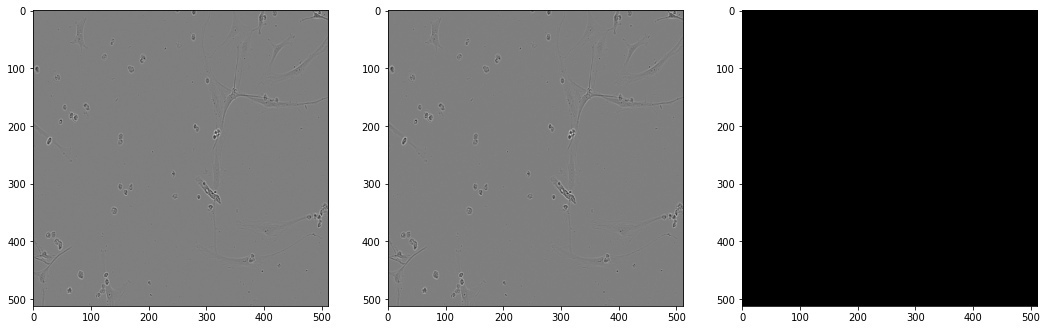

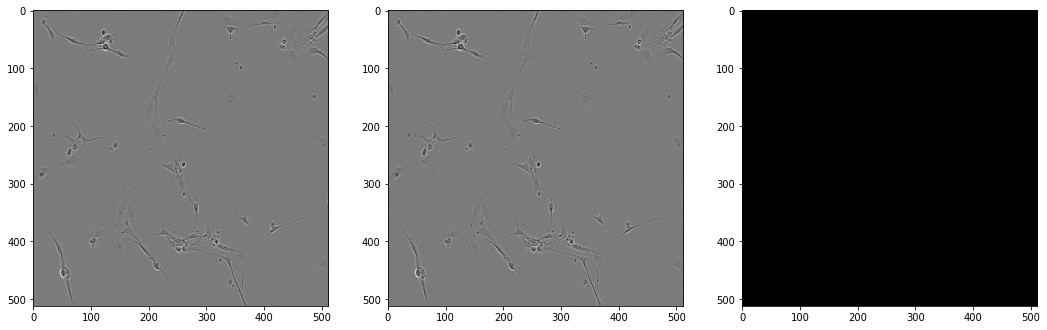

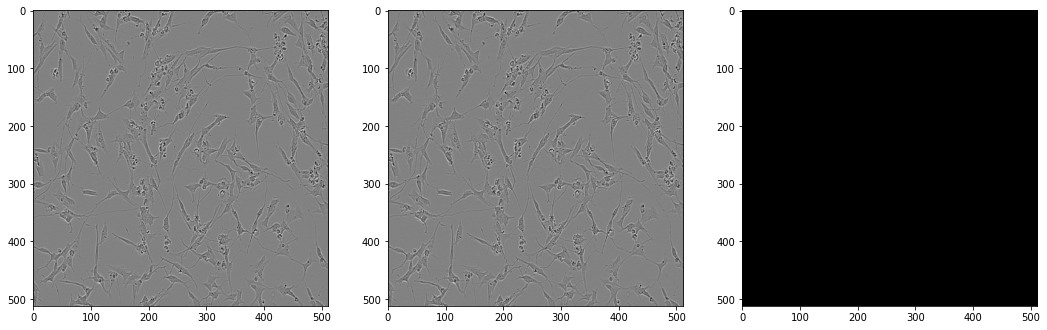

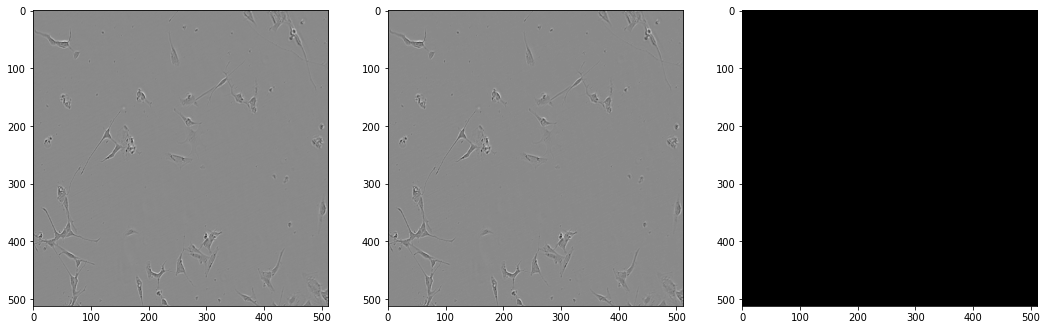

In [96]:
plot_predictions(val_images[:4], colormap, model=model)

In [12]:
model_path = 'C:/kaggletemp/sartorius-cell-instance-segmentation/models/models.h5'
xmodel = tf.keras.models.load_model(model_path, compile =False)


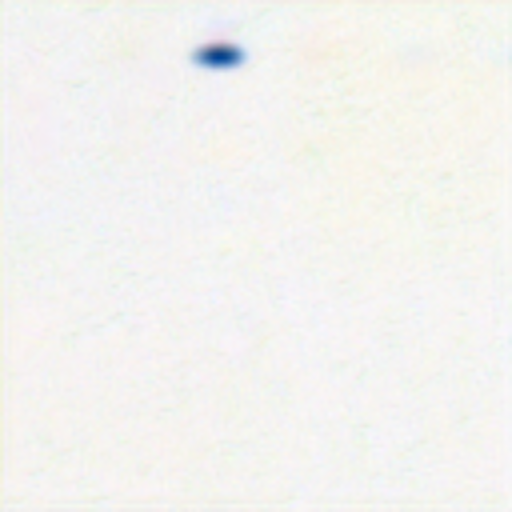

In [23]:
xmodel = model
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image =  tf.image.convert_image_dtype(image, dtype=tf.float32)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        #image = image / 255
       # image = tf.clip_by_value(image,0,1)
    return image


x = train_images[:4]
image_tensor = read_image(x[0])
prediction_mask = xmodel.predict(tf.expand_dims( image_tensor, axis=0) )
out = prediction_mask.squeeze()
tf.keras.utils.array_to_img(out)
#out.shape
m1 = read_image( train_masks[0], mask=True)
m1.shape
tf.keras.utils.array_to_img(out)
#tf.keras.utils.array_to_img(m1)

In [24]:
tf.reduce_min(out)

<tf.Tensor: shape=(), dtype=float32, numpy=-7.7919397>

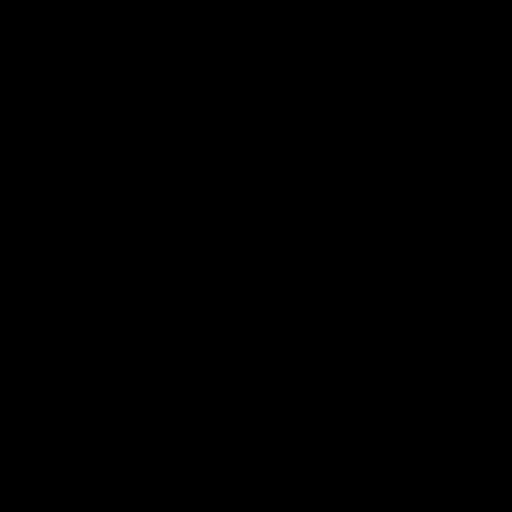

In [25]:
out1 = out > .3
out1 = out1 * 1
tf.keras.utils.array_to_img(out1)
#tf.reduce_min(out1)

outx = out1[:,:,0]
outx.shape
tf.keras.utils.array_to_img(tf.expand_dims(outx,axis= 2) )

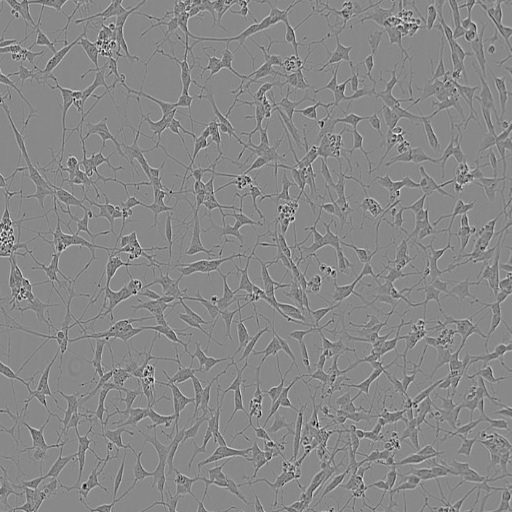

In [26]:
tf.keras.utils.array_to_img(read_image(x[0]))


In [27]:
tf.keras.utils.array_to_img(read_image(train_masks[0]))
x =read_image(train_masks[0], mask=True )
x

<tf.Tensor: shape=(512, 512, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

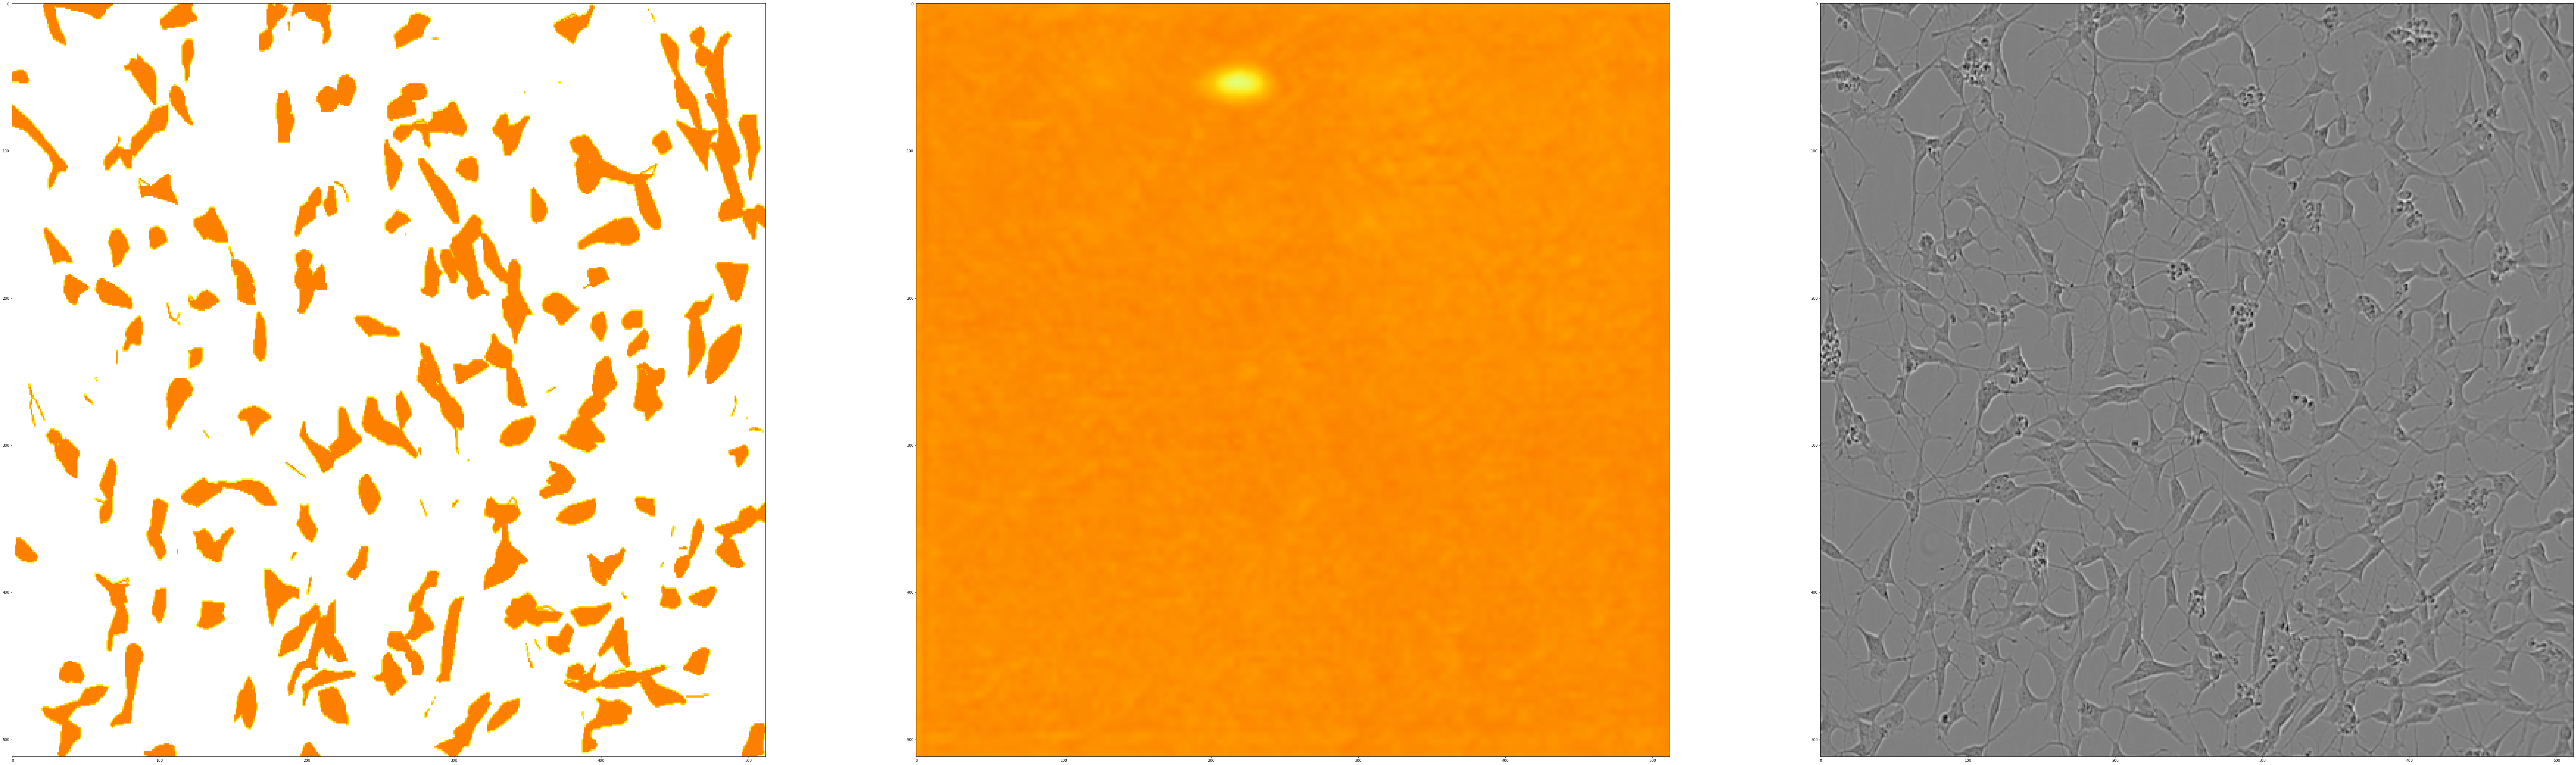

In [57]:
xmodel = model
import matplotlib.pyplot as plt
imask = read_image(  train_masks[0] )
#im1 = tf.expand_dims ( im1[:,:,0],axis= 2)
imask= imask[:,:,2]
imask  = np.ma.masked_where(imask==0, imask)

ipred = xmodel.predict(tf.expand_dims( read_image(train_images[0]), axis=0) )
ipred = ipred[0,:,:,2]
#ipred = ipred > .01
#ipred = ipred * 1
#ipred = np.ma.masked_where(ipred==0, ipred)


f, axarr = plt.subplots(1,3,figsize=(128, 128))
axarr[0].imshow(imask, cmap="Wistia")
axarr[2].imshow(read_image(  train_images[0] ))
axarr[1].imshow( ipred, cmap=  "Wistia")





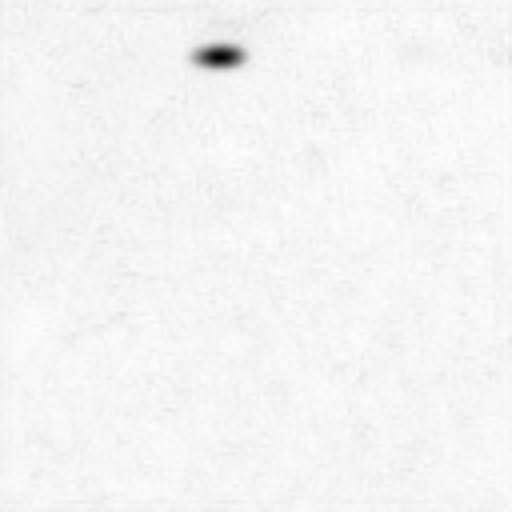

In [62]:

ipred = xmodel.predict(tf.expand_dims( read_image(train_images[0]), axis=0) )
ipred[0,:,:,0].shape
tf.keras.utils.array_to_img(ipred[0,:,: ,:1])

In [18]:
model


In [55]:
ipred = xmodel.predict(tf.expand_dims( read_image(train_images[0]), axis=0) )
ipred = ipred[0,:,:,]
( [tf.reduce_mean(ipred[:,:,0]), tf.reduce_mean(ipred[:,:,1]),tf.reduce_mean(ipred[:,:,2])     ])

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.3692642>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.3825432>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.46689418>]

In [39]:
ipred[:,:,0].shape

(512, 512)

In [63]:
train_images[0]

'C:/kaggletemp/sartorius-cell-instance-segmentation\\train\\0030fd0e6378.png'

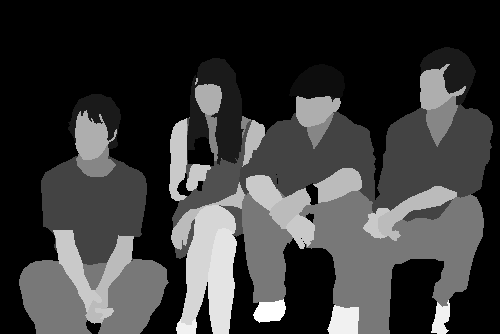

In [88]:
paths = 'C:/kaggletemp/sartorius-cell-instance-segmentation/instance-level_human_parsing/instance-level_human_parsing/Training/Category_ids/0000007.png'

image = tf.io.read_file(paths)
image = tf.image.decode_png(image)
image
tf.keras.utils.array_to_img(image)

In [92]:
x =  np.array(image)
#x = x.flatten()
np.unique(x) /127.5 -1
np.unique(x)
#x.shape

array([ 0,  1,  2,  5,  6,  9, 10, 13, 14, 15, 16, 17, 18, 19],
      dtype=uint8)

In [ ]:
array([[ 0,  0,  0],
       [50,  0,  0],
       [99,  0,  0],
       [ 0, 33,  0],
       [66,  0, 19],
       [99, 33,  0],
       [ 0,  0, 33],
       [ 0, 46, 86],
       [33, 33,  0],
       [ 0, 33, 33],
       [33, 19,  0],
       [20, 33, 50],
       [ 0, 50,  0],
       [ 0,  0, 99],
       [19, 66, 86],
       [ 0, 99, 99],
       [33, 99, 66],
       [66, 99, 33],
       [99, 99,  0],
       [99, 66,  0]], dtype=uint8)